# Predicting Republican and Democratic donations
## Part 1


下面以“预测共和党和民主党的捐款”为例，进行说明，数据下载[地址](https://www.dataquest.io/blog/large_files/input.csv)。


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# set seed to reproducibility
SEED = 222
np.random.seed(SEED)

In [6]:
#读取数据
df = pd.read_csv("/tmp/data_input/kaggle/Predicting_donations/input.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
cand_pty_affiliation    100000 non-null object
cand_office_st          100000 non-null object
cand_office             100000 non-null object
cand_status             100000 non-null object
rpt_tp                  100000 non-null object
transaction_tp          100000 non-null object
entity_tp               100000 non-null object
state                   100000 non-null object
classification          100000 non-null object
cycle                   100000 non-null float64
transaction_amt         100000 non-null float64
dtypes: float64(2), object(9)
memory usage: 8.4+ MB


从上图可以看出可以用到的属性：

- entity_tp: 用来区分是个人做出的预测还是组织做出的
- state: 捐款者的所在居住地（州）
- classification: 所工作的领域

- rpt_tp: 竞选过程中的捐献
- transaction_tp: 捐助的组成，竞选者自己还是政治委员会
- cycle: 竞选周期
- transaction_amt: 捐助的总额

- cand_pty_affiliation: 候选者所属党派的类别，这就是需要进行预测的特征
- cand_office_st: 参与州
- cand_office: 政府机关候选还是occupying
- cand_status: 政府机关参与候选的状态


In [7]:
df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [8]:
#处理数据
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size = 0.95):
    # 将数据分为训练集和测试集
    # 获取共和党的标签
    y = 1 * (df.cand_pty_affiliation == "REP")
    #去掉除共和党和民主党其他党派的捐款
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    
    return train_test_split(X, y, test_size=test_size)

In [9]:
#将原始数据处理为训练数据集和测试数据集
xtrain, xtest, ytrain, ytest = get_train_test()

print("\nData set :")

df.head()



Data set :


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


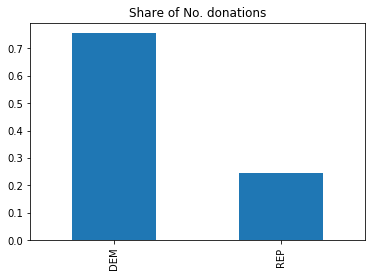

In [10]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind="bar", title="Share of No. donations")
plt.show()

从上图可以看出，大约有75%的捐款是给民主党的，接下来进行模型的集成，即结合多个模型的预测，对特异性误差取平均值，从而获得更好的整体预测效果

下面使用决策树来对模型进行预测。

为了更好的观察决策树的结果，需要对决策树进行可视化，环境需要准备：

- 安装 pip install pydotplus
- 安装 sudo apt-get install graphviz

In [11]:
#使用辅助函数对决策树进行可视化

import pydotplus  # you can install pydotplus with: pip install pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [12]:
def print_graph(clf, feature_names):
    # print decision tree
    graph = export_graphviz(clf,
                           label='root',
                           proportion=True,
                           impurity=False,
                           out_file=None,
                           feature_names=feature_names,
                           class_names={0:"D", 1:"R"},
                           filled=True,
                           rounded=True)
                    
    graph = pydotplus.graph_from_dot_data(graph)
    
    return Image(graph.create_png())


使用决策树对训练集进行训练，并通测试集对训练的模型进行交叉测试，进行性能测试

Decision Tree ROC-AUC score : 0.672



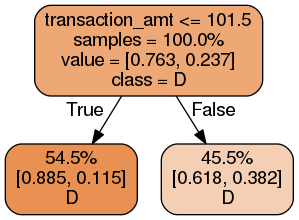

In [13]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
pre1 = t1.predict_proba(xtest)[:,1]

print("Decision Tree ROC-AUC score : %.3f\n" % roc_auc_score(ytest, pre1))
print_graph(t1, xtrain.columns)

每个叶节点记录它们在训练样本中的比例、类别分布和类别标签预测。我们的决策树根据捐款金额是否超过 101.5 进行预测，将更多的特征参数加入，构建多层的决策树进行观察，分别构建二层决策树和三层决策树

Decision Tree ROC-AUC score : 0.721



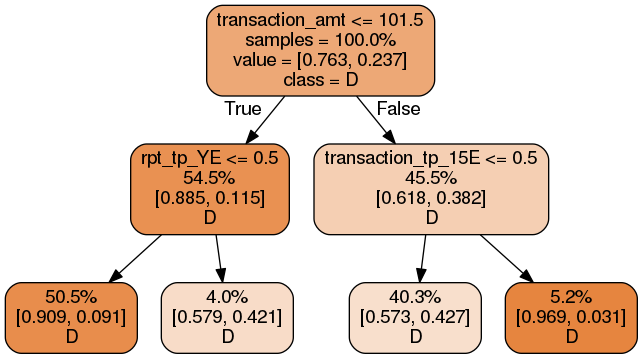

In [14]:
t2 = DecisionTreeClassifier(max_depth=2, random_state=SEED)
t2.fit(xtrain, ytrain)
pre2 = t2.predict_proba(xtest)[:,1]

print("Decision Tree ROC-AUC score : %.3f\n" % roc_auc_score(ytest, pre2))
print_graph(t2, xtrain.columns)

Decision Tree ROC-AUC score : 0.751



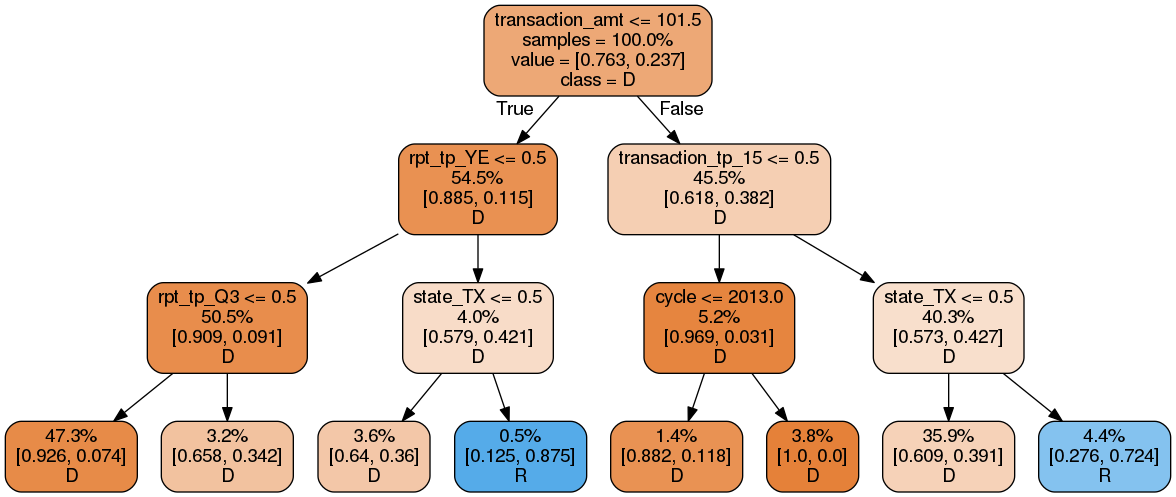

In [15]:
t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain, ytrain)
pre3 = t3.predict_proba(xtest)[:,1]

print("Decision Tree ROC-AUC score : %.3f\n" % roc_auc_score(ytest, pre3))
print_graph(t3, xtrain.columns)

可以看到三层的决策树并不比一层的决策树要好，共和党的预测率大约为5%，比25%差距不小，产生了过拟合。在固定层数的情况下，增加决策树的宽度也可以达到增加复杂度的目的。

由于我们关系的是捐助的分类，所以对捐助的总额不是很关心，所以考虑去掉transaction_amt的特征。

Decision Tree ROC-AUC score :%.3f
 0.740318258788


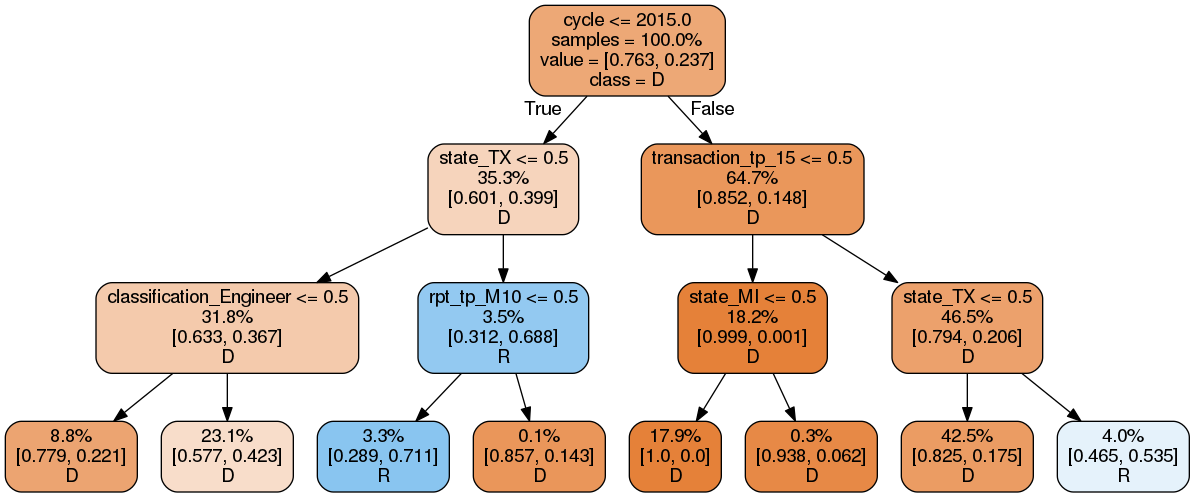

In [16]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, axis=1)
xtest_slim = xtest.drop(drop, axis=1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
pre3 = t3.predict_proba(xtest_slim)[:, 1]

print("Decision Tree ROC-AUC score :%.3f\n", roc_auc_score(ytest, pre3))
print_graph(t3, xtrain_slim.columns)

从结果上看出，对于共和党的分类大约为7.3%，比上一次使用决策树要好一些，这两个模型采用不同特征进行训练的决策，可以将这两个模型通过集成的方式，来减小预测误差。

目前集成学习根据个体生成器的的生成方式，大体分为两种类型，一是个体生成器之间有强依赖关系，必须串行生成序列，另外一种就是个体生成器之间不存在依赖关系，可以并行生成序列，前一种比较典型的方法是Boosting，后一种典型的方法时Bagging和Random Forest。

### 使用两个决策树进行集成

1、首先检查误差的关联性，高度关联的误差会引起差的集成


In [17]:
tree1 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
tree1.fit(xtrain, ytrain)
pre1 = tree1.predict_proba(xtest)[:, 1]

tree2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
tree2.fit(xtrain_slim, ytrain)
pre2 = tree2.predict_proba(xtest_slim)[:, 1]

#计算两者的协方差矩阵
pd.DataFrame({"full_data": pre1,
             "red_data": pre2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


可以看出方差还是有一些关联性，但是不是具有特别大的影响性。

2、平均两个模型的预测

In [18]:
pre_mean = np.mean([pre1, pre2], axis=0)

print("Average decision tree ROC-AUC score is \n", roc_auc_score(ytest, pre_mean))

Average decision tree ROC-AUC score is 
 0.782742456807


可以看出，经过平均后性能会有一定的提升，如果再有更多的决策树，将其进行平均也会有更好的性能提升。

从上述的模型训练中可以看出，特征参数的选择比较重要，那么如何进行特征参数的选择呢，一个快速有效的实践方法是随机地选择一个特征子集，在每个 draw 上拟合一个决策树并平均其预测。这一过程被称为自举平均（bootstrapped averaging，通常缩写为 bagging），它应用于决策树所产生的模型是随机森林。

In [19]:
#构建10个决策树的生成，每一个拟合包含3个特征的子集
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, # 10个决策树
                           max_features=3,   # 3个特征子集
                           random_state=SEED)
rf.fit(xtrain, ytrain)
pre = rf.predict_proba(xtest)[:, 1]

print("Average decision tree ROC-AUC score is \n", roc_auc_score(ytest, pre))


Average decision tree ROC-AUC score is 
 0.844018408542


## 采用其他的模型进行集成

采用集成的时候有两个方面的需要注意：

- 预测误差的关联性越低，效果越好
- 模型越多，效果越好

In [20]:
# 集成更多的模型来对数据进行训练
from sklearn.svm import SVC, LinearSVC  # 支持向量机
from sklearn.naive_bayes import GaussianNB # 高斯朴素贝叶斯
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # 随机森林和Boosting
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # K近邻
from sklearn.neural_network import MLPClassifier # 神经网络
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import make_pipeline

In [21]:
#生成基本的学习器
def get_models():
    nb = GaussianNB();
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False,  random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=10, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    
    models = {"svm": svc,
             "knn":knn,
             "native bayes": nb,
             "lr": lr,
             "nn": nn,
             "boosting": gb,
             "random forest": rf,
             }
    
    return models

In [22]:
# 开始进行模型的训练
def train_predict(models_list):
    # fit多个学习模型，并返回预测结果
    store = np.zeros((ytest.shape[0], len(models_list)))
    store = pd.DataFrame(store)
    
    print("Starting to fit\n")
    cols = list()
    for i, (name, model) in enumerate(models_list.items()):
        print("%s..." % name, end=" ", flush=False)
        model.fit(xtrain, ytrain)
        store.iloc[:, i] = model.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("model done\n")
    store.columns = cols
    print("Done\n")
    
    return store
        

In [23]:
# 构建预测模型
def score_model(y, store):
    print("Scoring model\n")
    for m in store.columns:
        score = roc_auc_score(y, store.loc[:, m])
        print ("%-26s: %.3f" % (m, score))
    print("Done\n")

In [24]:
models = get_models()
store = train_predict(models)
score_model(ytest, store)

Starting to fit

svm... model done

knn... model done

native bayes... model done

lr... model done

nn... model done

boosting... model done

random forest... model done

Done

Scoring model

svm                       : 0.850
knn                       : 0.779
native bayes              : 0.803
lr                        : 0.857
nn                        : 0.851
boosting                  : 0.823
random forest             : 0.844
Done



对于集成策略来讲，各个基本学习器之间的预测误差必须是不相等的.

### 安装mlens工具包
pip install mlens

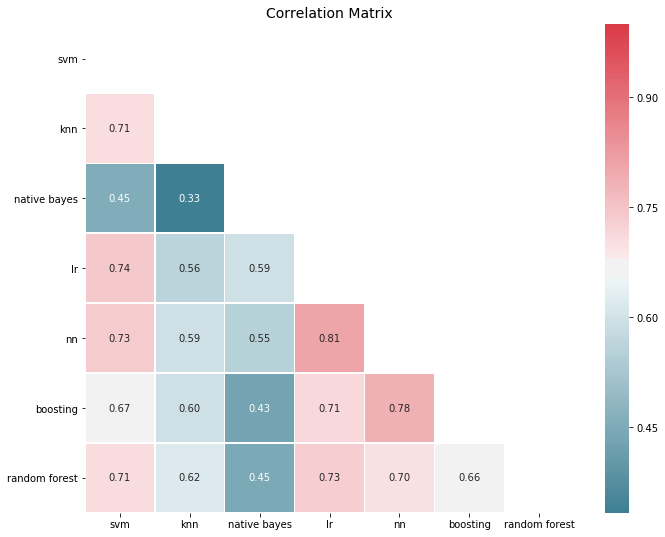

In [25]:
from mlens.visualization import corrmat
corrmat(store.corr(), inflate=False)
plt.show()

针对误差关联明显的，是可以进行预处理的，但是大多数误差的关联都在45%- 80%之间，可以对模型进行进一步的优化

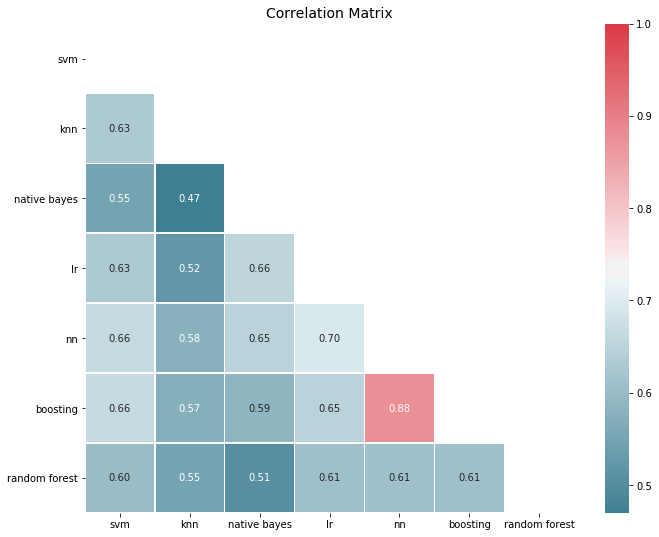

In [26]:
corrmat(store.apply(lambda pre: 1 * (pre > 0.5) - ytest.values).corr(), inflate=False)
plt.show()

继续对多个模型进行平均处理

In [31]:
print("Ensemble ROC-AUC score is %.3f"  % roc_auc_score(ytest, store.mean(axis=1)))

Ensemble ROC-AUC score is 0.882


画出roc曲线进行进一步的分析

In [32]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, p_base_learners, p_ensemble, labels, ens_label):
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    cm = [plt.cm.rainbow(i) for i in np.linspace(0, 1.0, p_base_learners.shape[1] + 1)]
    
    for i in range(p_base_learners.shape[1]):
        p = p_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label = labels[i], c=cm[i + 1])
    
    fpr, tpr, _ = roc_curve(ytest, p_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

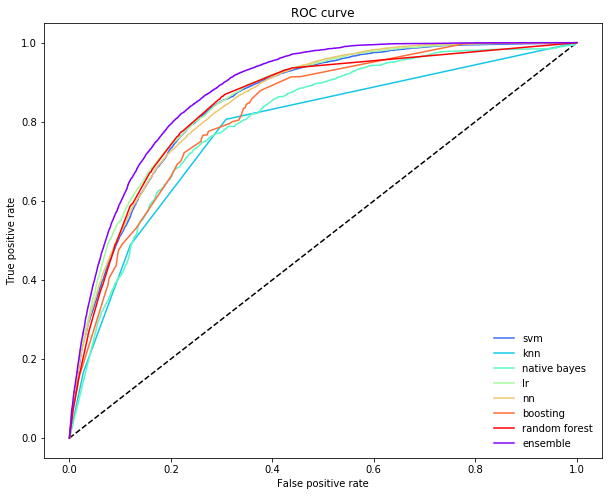

In [33]:
plot_roc_curve(ytest, store.values, store.mean(axis=1), list(store.columns), "ensemble")

采用平均法进行模型的集成会带来一些问题，有一些模型比其他的表现的性能更差，但是影响却一样大，这对于集成后整体的性能影比较大。
由于只需要预测对共和党的捐款情况，所以可以用这个来做参考标准，下面来简单的检查各个模型性能的表现情况。

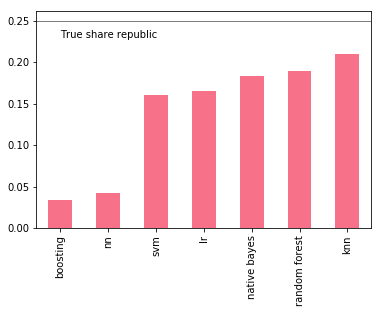

In [35]:
performance_diff = store.apply(lambda per: 1 * (per > 0.5).value_counts(normalize=True))
performance_diff.index = ["DEM", "REP"]
performance_diff.loc["REP",:].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republic")
plt.show()

去除比较差的模型，比如MLP-nn或者Boosting

In [42]:
current = [c for c in store.columns if c not in ["boosting"]]
print("Average roc score is %.3f" % roc_auc_score(ytest, store.loc[:, current].mean(axis=1)))

Average roc score is 0.880
